# Summarizing Abstract for Automatic Title Assignment (SAATA) Exploratory Data Analysis


**Description:** This notebook perform EDA on the [Kaggle arXiv Paper Abstracts](https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts) dataset, which includes 38,972 entries of academic papers (written in English) sourced from free distribution, open access archives arXiv portal

The EDA will providew basic information and characteristics of the paper abstracts and their respective titles. We aim to utilize this information to assist our data pre-processing and our NLP text suumarization models (that generate a predicted title as summary given an abstract of a paper as an input) improvement.


## Install and import necessary packages

In [ ]:
!pip install -q sentencepiece

     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [ ]:
!pip install -q transformers

     |████████████████████████████████| 5.3 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 27.4 MB/s 
     |████████████████████████████████| 163 kB 44.4 MB/s 


In [ ]:
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q bleu
import evaluate

     |████████████████████████████████| 72 kB 790 kB/s 
     |████████████████████████████████| 212 kB 10.2 MB/s 
     |████████████████████████████████| 115 kB 62.8 MB/s 
     |████████████████████████████████| 441 kB 45.4 MB/s 
     |████████████████████████████████| 127 kB 46.4 MB/s 
     |████████████████████████████████| 115 kB 37.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from pprint import pprint

import nltk
import string

from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration
from transformers import BartTokenizer, TFBartForConditionalGeneration

## Load arxiv Dataset

In [ ]:
github_data_url = 'https://raw.githubusercontent.com/maverickmaxx/summarizing_abstract/master/data/raw/arxiv_data_210930-054931.csv?token=GHSAT0AAAAAABQ3S5TNBDWOUH73RX6F6GO4Y257S7A'
arxiv = pd.read_csv(github_data_url)

In [ ]:
arxiv.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


In [ ]:
#arxiv = pd.read_pickle('normalized_arxiv.parquet')

## EDA

#### Basic Info on Arxiv Papers Dataset

In [ ]:
print(f"There are {len(arxiv)} rows in the dataset.")

There are 56181 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(arxiv["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 15076 duplicate titles.


In [ ]:
arxiv = arxiv[~arxiv["titles"].duplicated()]
print(f"There are {len(arxiv)} rows after dedeuplicating the dataset.")

There are 41105 rows after dedeuplicating the dataset.


### Average Word Counts of Arxiv Papers Titles and Abstracts

In [ ]:
arxiv['titles_wc'] = arxiv['titles'].str.split().str.len()
arxiv['abstracts_wc'] = arxiv['abstracts'].str.split().str.len()
arxiv['titles_abstracts_wc_ratio'] = arxiv['titles_wc']/arxiv['abstracts_wc']
#arxiv['titles_wc'] = arxiv['titles'].str.count(' ') + 1
#arxiv['abstracts_wc'] = arxiv['abstracts'].str.count(' ') + 1

In [ ]:
#print(f'The average word count of titles: {arxiv["titles_wc"].mean():.2f}')
#print(f'The average word count of abstracts: {arxiv["abstracts_wc"].mean():.2f}')
#print(f'The average title to abstract word count ratio: {arxiv["titles_abstracts_wc_ratio"].mean():.2f}')

print(f'The statistics of word count of titles: \n{arxiv["titles_wc"].describe()}\n')
print(f'The statistics of word count of abstracts: \n{arxiv["abstracts_wc"].describe()}\n')
print(f'The statistics of title to abstract word count ratio: \n{arxiv["titles_abstracts_wc_ratio"].describe()}\n')

The statistics of word count of titles: 
count    41105.000000
mean         8.902299
std          3.039716
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         30.000000
Name: titles_wc, dtype: float64

The statistics of word count of abstracts: 
count    41105.000000
mean       171.467340
std         45.954856
min          5.000000
25%        140.000000
50%        169.000000
75%        201.000000
max        498.000000
Name: abstracts_wc, dtype: float64

The statistics of title to abstract word count ratio: 
count    41105.000000
mean         0.055793
std          0.032031
min          0.003745
25%          0.039216
50%          0.051282
75%          0.066667
max          3.600000
Name: titles_abstracts_wc_ratio, dtype: float64



On average, the title length is around 9 words while the abstract length is around 170 words. The average title length to abstract length ratio is around 5%, meaning our model aims to summarize an input corpus text of 170 words into a summary title with around 9 words in length.

### Word Counts Distribution of Arxiv Papers Titles and Abstracts

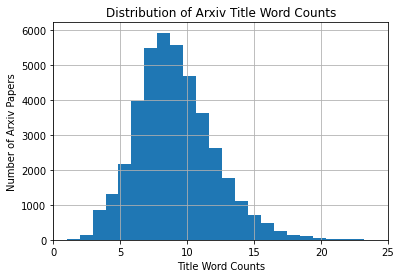

In [ ]:
arxiv["titles_wc"].hist(bins=30)
plt.xlim([0,25])
plt.xlabel("Title Word Counts")
plt.ylabel("Number of Arxiv Papers")
plt.title("Distribution of Arxiv Title Word Counts")
plt.show()

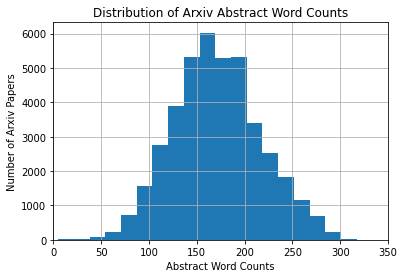

In [ ]:
arxiv["abstracts_wc"].hist(bins=30)
plt.xlim([0,350])
plt.xlabel("Abstract Word Counts")
plt.ylabel("Number of Arxiv Papers")
plt.title("Distribution of Arxiv Abstract Word Counts")
plt.show()

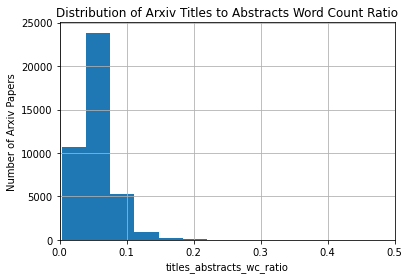

In [ ]:
arxiv["titles_abstracts_wc_ratio"].hist(bins=100)
plt.xlim([0,0.5])
plt.xlabel("titles_abstracts_wc_ratio")
plt.ylabel("Number of Arxiv Papers")
plt.title("Distribution of Arxiv Titles to Abstracts Word Count Ratio")
plt.show()

Based on our dataset, the title word count and abstract word count has a Gaussian distribution, while the title-to-abstract word count ratios are mainly around 0.05 (5%), with a right tail dropoff.

#### Examine Most/Least Frequent (Non-Stop) N-grams in Titles/Abstracts

Here we examin the most/least frequent n-gram appear in the Arxiv paper titles and abstracts:

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def normalize(text):
    lemmatizer  = nltk.WordNetLemmatizer()
    stopwords   = set(nltk.corpus.stopwords.words('english'))
    punctuation = string.punctuation
    stemedList  = []
    result      = []
    # tokenization
    for token in nltk.word_tokenize(text):
        token = token.lower()
        # stemming
        token = nltk.PorterStemmer().stem(token)
        # lemmatization
        token = lemmatizer.lemmatize(token)
        if token not in stopwords and token not in punctuation:
            result.append(token)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
arxiv['normalized_titles'] = arxiv['titles'].apply(normalize)
arxiv['normalized_titles'].head()

0    [multi-level, attent, pool, graph, neural, net...
1    [decis, forest, v, deep, network, conceptu, si...
2    [power, robust, graph, convolut, network, via,...
3    [releas, graph, neural, network, differenti, p...
4    [recurrence-awar, long-term, cognit, network, ...
Name: normalized_titles, dtype: object

In [ ]:
arxiv['normalized_abstracts'] = arxiv['abstracts'].apply(normalize)
arxiv['normalized_abstracts'].head()

0    [graph, neural, network, gnn, wide, use, learn...
1    [deep, network, decis, forest, random, forest,...
2    [graph, convolut, network, gcn, power, tool, g...
3    [increas, popular, graph, neural, network, gnn...
4    [machin, learn, solut, pattern, classif, probl...
Name: normalized_abstracts, dtype: object

Save normalized dataset in parquet format

In [ ]:
arxiv.to_parquet('normalized_arxiv.parquet')
from google.colab import files
files.download("normalized_arxiv.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The 10 Most Frequent Words Appear in Titles:

In [ ]:
pd.Series(arxiv.explode('normalized_titles')['normalized_titles']).value_counts()[:10]

learn      12145
network     7713
deep        4860
imag        4808
neural      4004
use         3898
detect      3765
gener       3602
model       3497
graph       3007
Name: normalized_titles, dtype: int64

The 10 Leaset Frequent Words Appear in Titles:

In [ ]:
pd.Series(arxiv.explode('normalized_titles')['normalized_titles']).value_counts()[-10:]

high-dynamic-rang    1
the______            1
chatpaint            1
recist               1
hdri                 1
fusedgan             1
oolit                1
limeston             1
gazegan              1
wav2lett             1
Name: normalized_titles, dtype: int64

The 10 Most Frequent Words Appear in Abstracts:

In [ ]:
pd.Series(arxiv.explode('normalized_abstracts')['normalized_abstracts']).value_counts()[:10]

learn      64053
model      59945
thi        59130
method     49262
imag       47044
propos     46621
use        45022
network    43551
data       36527
gener      34778
Name: normalized_abstracts, dtype: int64

The 10 Least Frequent Words Appear in Abstracts:

In [ ]:
pd.Series(arxiv.explode('normalized_abstracts')['normalized_abstracts']).value_counts()[-10:]

kiiti             1
2,3,4             1
keepaug           1
215,986           1
callback          1
industrial-rel    1
mvgg19            1
6.95              1
extra-long        1
-svd              1
Name: normalized_abstracts, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def top_ngram(corpus, ngram=1, top_n=10):
    word_vectorizer = CountVectorizer(ngram_range=(ngram,ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(corpus)
    frequencies = sparse_matrix.sum(axis=0)[0]
    result = pd.DataFrame(frequencies.transpose(), index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by=['frequency'], ascending=False)
    return result.head(top_n)
    #return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

The 10 Most Frequent Bigram in Titles:

In [ ]:
top_ngram(arxiv['titles'], 2, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
reinforcement learning,2824
neural networks,2119
learning for,1663
object detection,1606
network for,1334
deep learning,1198
networks for,994
generative adversarial,986
neural network,982
time series,971


The 10 Most Frequent Bigram in Abstracts:

In [ ]:
top_ngram(arxiv['abstracts'], 2, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
of the,57747
in the,24837
in this,22421
we propose,19236
on the,18290
this paper,18233
to the,17437
state of,15867
the art,15068
show that,13225


The 10 Most Frequent Trigram in Titles:

In [ ]:
top_ngram(arxiv['titles'], 3, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
deep reinforcement learning,690
generative adversarial networks,666
graph neural networks,474
convolutional neural networks,474
neural networks for,367
deep neural networks,357
reinforcement learning for,349
end to end,325
reinforcement learning with,300
person re identification,261


The 10 Most Frequent Trigram in Abstracts:

In [ ]:
top_ngram(arxiv['abstracts'], 3, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
state of the,15436
of the art,15045
in this paper,13491
this paper we,12086
we show that,5217
in this work,5142
this work we,4736
paper we propose,4620
the state of,4253
as well as,3734


#### Wordcloud Visualizaiton

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

Wordcloud on Titles

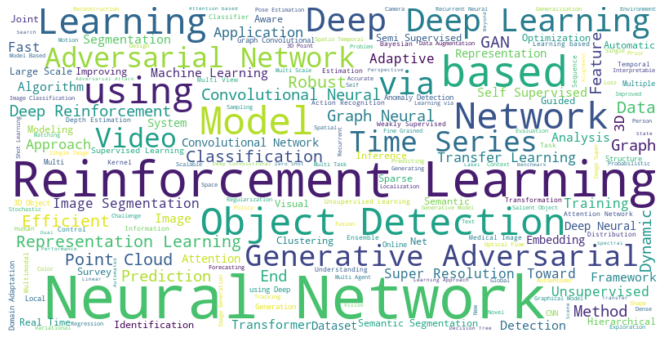

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))
wordcloud_titles = WordCloud(width=800,height=400,stopwords=stopwords,background_color="white").generate(' '.join(arxiv['titles']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud on Abstracts

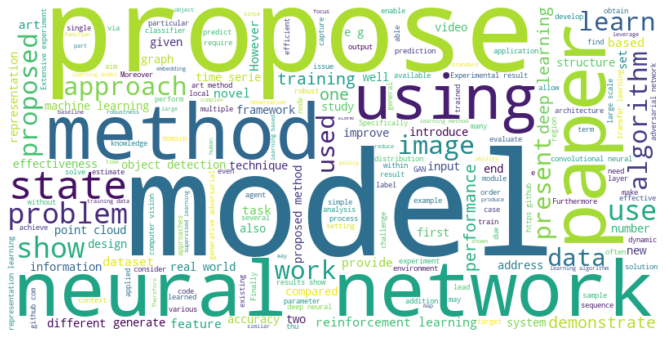

In [ ]:
wordcloud_abstracts = WordCloud(width=800,height=400,stopwords=stopwords,background_color="white").generate(' '.join(arxiv['abstracts']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_abstracts, interpolation='bilinear')
plt.axis("off")
plt.show()